STEPS for Matlab
---------------

STEPS for MATLAB is an auxiliary module for STEPS that allows it to be integrated into Matlab. It implements a subset of the Matlab Simbiology toolbox functionality. Please refer to the _[Matlab Simbiology documentation]()_ for further details.

This tutorial builds a model with multiple compartments and several events. The events change the number of a molecular species or the reaction rate of a reaction.

Matlab Simbiology is in contrast to STEPS not a spatial solver but a well-mixed solver. It supports multiple compartments that may be nested and allows reaction events between the molecular species of different compartments. The STEPS well-mixed solvers 'wmrk4' and 'wmdirect' 

STEPS requires volumes, molecular concentrations, and reaction rates to have units while Matlab 

### Major differences between STEPS and Matlab Simbiology:
- STEPS is inherently a spatial similator but also offers the simulation of well-mixed reation systems using the Runge-Kutta-based deterministic solver 'wmrk4' and the stochastic solver implementing the SSA 'wmdirect',
- Matlab Simbiology is a well-mixed solver not aware of complex spatial geometries. However, it is supported multiple, potentially nested, compartments,
- STEPS is aware what happens on the surface of compartments, Matlab focuses on simulating the reactions within,
- Matlab supports various kinetic laws while STEPS requires the law of mass action. 

### Limitations:
- no repeated assignments in events,
- only supports the '[t, x, names]' return value format. While Matlab Simbiology only supports a single realisation using this convention, STEPS for Matlab supports ensembles. 'x' is extended from a Matlab array to a cell array where each cell contains the time evolution data of one realisation. The time vector 't' and the list of molecular species 'names' are unchanged,
- if a reaction rate is changed by an event, the same units as in the model are assumed,
- only volume - volume reactions since Matlab does not support the concept of molecules embedded in surfaces,
- the volume of compartments is assumed to be constant.

### Reaction rate units supported:
- '1/second',
- '1/(micromolarity*second)',
- '1/(nanomolarity*second)',
- 'micromol/second',
- 'nanomol/second'.

### Compartment volume units supported:
- 'l' or 'liter',
- 'ml' or milliliter',
- 'mul' or 'microliter',
- 'nl' or 'nanoliter'.

STEPS requires a unit to be attached to each value while Matlab does not. Please see the _[STEPS tutrial on simulating a well mixed system]()_ for details.

### Installation
In order to run this tutorial, Matlab and the [Matlab API for Python](https://www.mathworks.com/help/matlab/matlab-engine-for-python.html) needs to be installed.

Also, STEPS for Matlab need to be in the Matlab search path. The steps.utilities.matlab_support Python module exposes the abs_path variable readable by Matlab:

In [1]:
steps_mod = py.importlib.import_module('steps.utilities.matlab_support');
addpath(char(steps_mod.abs_path))

Error using <frozen importlib>_call_with_frames_removed (line 321)
Python Error: SyntaxError: Missing parentheses in call to 'print' (__init__.py, line 39)

Error in <frozen importlib>source_to_code (line 1532)

Error in <frozen importlib>get_code (line 1572)

Error in <frozen importlib>exec_module (line 1467)

Error in <frozen importlib>_exec (line 1129)

Error in <frozen importlib>_load_unlocked (line 1200)

Error in <frozen importlib>_find_and_load_unlocked (line 2226)

Error in <frozen importlib>_find_and_load (line 2237)

Error in <frozen importlib>_gcd_import (line 2254)

Error in <frozen importlib>_call_with_frames_removed (line 321)

Error in <frozen importlib>_find_and_load_unlocked (line 2212)

Error in <frozen importlib>_find_and_load (line 2237)

Error in <frozen importlib>_gcd_import (line 2254)

Error in <frozen importlib>_call_with_frames_removed (line 321)

Error in <frozen importlib>_find_and_load_unlocked (line 2212)

Error in <frozen importlib>_find_and_load (line 22

### Dimerisation-decay model

This example is taken from Gillespie(1977). Construct the model and add a compartment. STEPS requires each part of the model such as a compartment or reaction rate to have a unit. For compartments, STEPS uses SI units with is  m3m3 . STEPS for Matlab converts the unit given in the Matlab model automatically:

In [2]:
model = sbiomodel('Decaying-Dimerizing Reaction Set');
c = addcompartment(model, 'c');
c.CapacityUnits = 'nanoliter';
c.Capacity = 1;

Add the molecular species 's1', 's2', and 's3'. Matlab assigns species to compartments. STEPS assigns them to the top level model but allows different initial conditions per compartment. 

In [3]:
s1 = addspecies(c, 's1', 'InitialAmount', 1e-4, 'InitialAmountUnits', 'micromolarity');
s2 = addspecies(c, 's2', 'InitialAmount', 0, 'InitialAmountUnits', 'micromolarity');
s3 = addspecies(c, 's3', 'InitialAmount', 0, 'InitialAmountUnits', 'micromolarity');

Add the reactions. Species 's1' either decays or dimerises forming 's2' in reaction 'r1' and 'r2', respectively. Reaction 'r3' converts species 's2' into 's3'. 

In [4]:
r1 = addreaction(model, 's1 -> null');
r2a = addreaction(model, 's1 + s1 -> s2');
r2b = addreaction(model, 's2 -> 2 s1');
r3 = addreaction(model, 's2 -> s3');

The next four cells set up the reaction Kinetics. STEPS only supports the law of mass action while Matlab supports a broader range. This tutorial follows the Matlab approach to create a kinetic law objetc per reaction:

In [5]:
kl1 = addkineticlaw(r1, 'MassAction');
kl2a = addkineticlaw(r2a, 'MassAction');
kl2b = addkineticlaw(r2b, 'MassAction');
kl3 = addkineticlaw(r3, 'MassAction');

In [6]:
p1  = addparameter(kl1, 'c1',  'Value', 1.0, 'ValueUnits', '1/second');
p2f = addparameter(kl2a, 'c2f', 'Value', 0.2, 'ValueUnits', '1/(micromolarity*second)');
p2r = addparameter(kl2b, 'c2r', 'Value', 0.5, 'ValueUnits', '1/second');
p3  = addparameter(kl3, 'c3',  'Value', 0.04, 'ValueUnits', '1/second');

In [7]:
kl1.ParameterVariableNames = {'c1'};
kl2a.ParameterVariableNames = {'c2f'};
kl2b.ParameterVariableNames = {'c2r'};
kl3.ParameterVariableNames = {'c3'};

Introspection of the model to verify all the required components are in place.

In [11]:
r = model.get('Reactions');
r(1).get('KineticLaw').get('Parameters').get()
r(2).get('KineticLaw').get('Parameters').get()
p = model.get('Parameters');

       Annotation: ''
    ConstantValue: 1
             Name: 'c1'
            Notes: ''
           Parent: [1×1 SimBiology.KineticLaw]
              Tag: ''
             Type: 'parameter'
         UserData: []
            Value: 1
       ValueUnits: '1/second'

       Annotation: ''
    ConstantValue: 1
             Name: 'c2f'
            Notes: ''
           Parent: [1×1 SimBiology.KineticLaw]
              Tag: ''
             Type: 'parameter'
         UserData: []
            Value: 0.2000
       ValueUnits: '1/(micromolarity*second)'



Simulate the model using Matlab's 'sbiosimulate' using the stochastic 'SSA' solver and plot the results. Please be aware that the sequence of species in the data is not necessarily the same as in Matlab's 'sbiosimulate':

Stochastic solvers expect integer initial amounts for species. A fractional initial amount was found for species named 's1'. It was rounded to the nearest integer.

> In sbiosimulate (line 140)


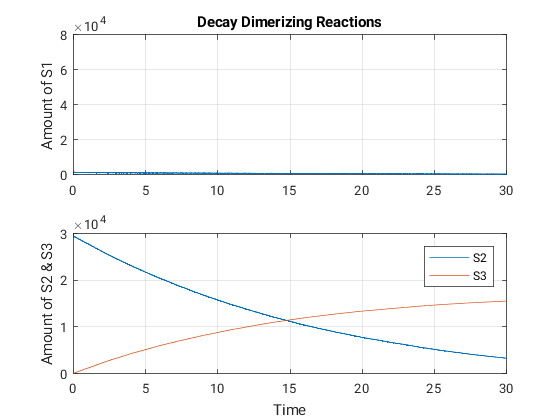

In [12]:
cs = getconfigset(model,'active');
p2f.Value = 6.022e6;
p2f.ValueUnits = '1/(micromolarity*second)';
cs.SolverType = 'ssa';
cs.StopTime = 30;

co = get(cs,'CompileOptions');
set(co,'UnitConversion', true);

%solver = cs.SolverOptions;
%solver.LogDecimation = 10;
%cs.CompileOptions.DimensionalAnalysis = false;
[t_ssa, x_ssa] = sbiosimulate(model);

% scale to the numer of molecules
x_ssa = x_ssa .* (6.022e23 * 1e-6 *1e-9);

h1 = subplot(2,1,1);
plot(h1, t_ssa, x_ssa(:,1));
h2 = subplot(2,1,2);
plot(h2, t_ssa, x_ssa(:,2:3));
grid(h1,'on'); 
grid(h2,'on');
title(h1,'Decay Dimerizing Reactions');
ylabel(h1,'Amount of S1');
ylabel(h2,'Amount of S2 & S3');
xlabel(h2,'Time');
legend(h2, 'S2', 'S3');

Simulate using STEPS for Matlab using STEPS stochastic 'wmdirect' solver:

In [9]:
p2f.Value = 6.022e6;
p2f.ValueUnits = '1/(micromolarity*second)'

addpath('/home/guido/Documents/STEPS/MATLAB_STEPS_interaction', '/home/guido/Documents/STEPS/MATLAB_STEPS_interaction/steps_for_matlab')

[t, x, names] = run_steps(model, 'stoptime', 30, 'realisations', 1, 'modeltofile', true);


   SimBiology Parameter Array

   Index:    Name:    Value:       ValueUnits:
   1         c2f      6.022e+06    1/(micromolarity*second)

              dt: 0.1000
     modeltofile: 1
    realisations: 1
           rk4dt: 1.0000e-05
            seed: 0
          solver: 'wmdirect'
        stoptime: 30


   SimBiology Compartment - c 

   Compartment Components:
     Capacity:          1
     CapacityUnits:     nanoliter
     Compartments:      0
     ConstantCapacity:  true
     Owner:             
     Species:           3


   SimBiology Compartment - c 

   Compartment Components:
     Capacity:          1
     CapacityUnits:     nanoliter
     Compartments:      0
     ConstantCapacity:  true
     Owner:             
     Species:           3


   SimBiology Compartment - c 

   Compartment Components:
     Capacity:          1
     CapacityUnits:     nanoliter
     Compartments:      0
     ConstantCapacity:  true
     Owner:             
     Species:           3


   SimBiology

{"data": [[[[60221.0, 0.0, 0.0], [60221.0, 0.0, 0.0], [1210.0, 29258.0, 109.0], [1134.0, 29120.0, 232.0], [1163.0, 28899.0, 382.0], [1176.0, 28719.0, 490.0], [1149.0, 28574.0, 590.0], [1128.0, 28414.0, 707.0], [1133.0, 28248.0, 816.0], [1166.0, 28073.0, 920.0], [1151.0, 27901.0, 1049.0], [1140.0, 27714.0, 1183.0], [1103.0, 27561.0, 1299.0], [1128.0, 27380.0, 1405.0], [1125.0, 27223.0, 1506.0], [1121.0, 27058.0, 1618.0], [1137.0, 26885.0, 1715.0], [1141.0, 26733.0, 1817.0], [1144.0, 26566.0, 1925.0], [1114.0, 26407.0, 2040.0], [1152.0, 26233.0, 2136.0], [1135.0, 26089.0, 2222.0], [1117.0, 25951.0, 2320.0], [1049.0, 25828.0, 2430.0], [1119.0, 25654.0, 2518.0], [1109.0, 25494.0, 2623.0], [1165.0, 25313.0, 2725.0], [1077.0, 25202.0, 2825.0], [1155.0, 25008.0, 2923.0], [1094.0, 24872.0, 3030.0], [1087.0, 24718.0, 3133.0], [1105.0, 24559.0, 3218.0], [1085.0, 24437.0, 3299.0], [1033.0, 24304.0, 3399.0], [1027.0, 24168.0, 3492.0], [1052.0, 24016.0, 3584.0], [1068.0, 23867.0, 3680.0], [1068.0, 

and also plot the results:

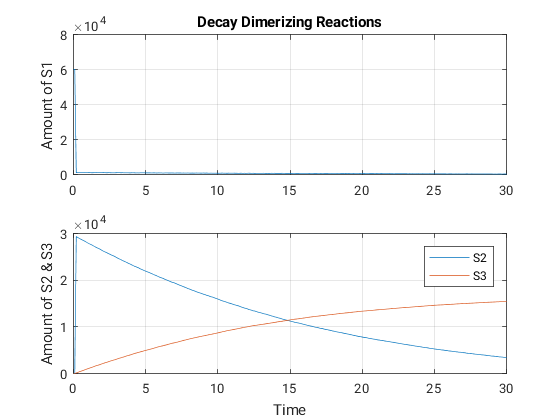

In [81]:
figure;
h1 = subplot(2,1,1);
plot(t, x{1}(:,1));
h2 = subplot(2,1,2);
plot(t, x{1}(:,2), t, x{1}(:,3));
grid(h1,'on'); 
grid(h2,'on');
title(h1,'Decay Dimerizing Reactions');
ylabel(h1,'Amount of S1');
ylabel(h2,'Amount of S2 & S3');
xlabel(h2,'Time');
legend(h2, 'S2', 'S3');

### Diffusion between compartments and events

Construct the model and add two compartments 'a' and 'b' with the volume of 1 liter each to it:

In [39]:
model = sbiomodel('Two_compartment_diffusion');
a = addcompartment(model, 'a');
b = addcompartment(model, 'b');
a.CapacityUnits = 'liter';
b.CapacityUnits = 'liter';

Add the molecular species 'x', 'y', 'z'. The species 'n' is the sink for decyed molecules. Matlab assigns species to compartments. STEPS assigns them to the top level model but allows different initial conditions per compartment. 

In [40]:
% species
x_a = addspecies(a, 'x', 'InitialAmount', 1000, 'InitialAmountUnits', 'molecule');
x_b = addspecies(b, 'x', 'InitialAmount', 0, 'InitialAmountUnits', 'molecule');
y_a = addspecies(a, 'y', 'InitialAmount', 0, 'InitialAmountUnits', 'molecule');
y_b = addspecies(b, 'y', 'InitialAmount', 1000, 'InitialAmountUnits', 'molecule');
z_a = addspecies(a, 'z', 'InitialAmount', 2000, 'InitialAmountUnits', 'molecule');
n_a = addspecies(a, 'n', 'InitialAmount', 0, 'InitialAmountUnits', 'molecule');

Matlab uses a 'compartment.specie' notation distinguish molecular species within different compartments. Reactions involving two compartments are translated into STEPS surface reactions. A STEPS patch is automatically created. Reactions involving more than two compartments are not supported.

There are two compartments 'a' and 'b' in this example. Molecules of species 'x' and 'y' can diffuse from one compartment to the other as given in reaction 'r1' to 'r4'. Furthermore, species 'z' is limited to compartment 'a' and decays.

In [3]:
% reactions
r1 = addreaction(model, 'a.x -> b.x');
r2 = addreaction(model, 'b.x -> a.x');
r3 = addreaction(model, 'a.y -> b.y');
r4 = addreaction(model, 'b.y -> a.y');
r5 = addreaction(model, 'a.z -> a.n');

As in the previous example, the next four cells set up the reaction Kinetics. STEPS only supports the law of mass action while Matlab supports a broader range. This tutorial follows the Matlab approach to create a kinetic law objetc per reaction:

In [4]:
% Set the kinetic law
kl1 = addkineticlaw(r1, 'MassAction');
kl2 = addkineticlaw(r2, 'MassAction');
kl3 = addkineticlaw(r3, 'MassAction');
kl4 = addkineticlaw(r4, 'MassAction');
kl5 = addkineticlaw(r5, 'MassAction');

as well as a parameter for the reation rate of each reaction. In order to modify the reaction rates by an event during the course of the simulation, the parameters have to be defined as non-constant: 

In [5]:
% Add rate constant parameter, c2, to kinetic law with value = 0.01
p1 = addparameter(model, 'c1', 'Value', 0.25, 'ConstantValue', false);
p2 = addparameter(model, 'c2', 'Value', 0.25, 'ConstantValue', false);
p3 = addparameter(model, 'c3', 'Value', 0.25, 'ConstantValue', false);
p4 = addparameter(model, 'c4', 'Value', 0.25, 'ConstantValue', false);
p5 = addparameter(model, 'c5', 'value', 0.1, 'ConstantValue', false);

The reaction rates are linked to the kinetic laws and with it to the reaction by setting the \ParameterVariableNames\ property of the kinetic law to the name of the desired parameter:

In [6]:
set(kl1, 'ParameterVariableNames', {'c1'});
set(kl2, 'ParameterVariableNames', {'c2'});
set(kl3, 'ParameterVariableNames', {'c3'});
set(kl4, 'ParameterVariableNames', {'c4'});
set(kl5, 'ParameterVariableNames', {'c5'});

STEPS requires units for each part of the model. For reaction rates steps requires the molecular concentration part of the rate to be given in $\frac{Mol}{liter}$. STEPS for Matlab automatically converts the units.

In [7]:
% Add units to c2
p1.ValueUnits = '1/second';
p2.ValueUnits = '1/second';
p3.ValueUnits = '1/second';
p4.ValueUnits = '1/second';
p5.ValueUnits = '1/second';

Add the events. An event has a trigger \time\ which gives the simulation time when the event occurs and a string defining what shall happen. Matlab supports arbitrary Matlab code such as function call in events. STEPS for Matlab only supports assigning a value to a molecular species and reaction rates. 

It is assumed that the variables changed by the event have the same units as in molecular concentration as in the earlier model definition.

In [8]:
% add a simple event, at t=15 we set x_a=1000 and y_b=1000
e1 = addevent(model, 'time>=15', {'a.x = 1000', 'b.y = 1000'});
e2 = addevent(model, 'time>=10', 'a.x = 0');
e3 = addevent(model, 'time>=20', 'a.z = 0');
e4 = addevent(model, 'time>=5', 'c5 = 0');
e5 = addevent(model, 'time>=15', 'c5 = 0.1');

Introspect the model and the parameters. The model got 2 compartments, 5 reactions with a parameter each, 6 molecular species, and 5 events:

In [9]:
model
model.get('Events')


   SimBiology Model - Two_compartment_diffusion 

   Model Components:
     Compartments:      2
     Events:            5
     Parameters:        5
     Reactions:         5
     Rules:             0
     Species:           6


   SimBiology Event Array

   Index:    Trigger:    EventFcns:
   1         time>=15    a.x = 1000
                         b.y = 1000
   2         time>=10    a.x = 0
   3         time>=20    a.z = 0
   4         time>=5     c5 = 0
   5         time>=15    c5 = 0.1



Simulate the model using Matlab's Simbiology solver up to 't = 30' seconds:

In [26]:
% this would be running the simulation using Matlab simbiology
cs = getconfigset(model,'active');
% cs.SolverType = 'ssa';
cs.StopTime = 30;
[t, x, names] = sbiosimulate(model);

and plot the results. STEPS for Matlab only supports the '[t, x, name]' return value convention of 'sbiosimulate' where 'x' denotes the vector of time points, 'x' the array containing the time evoluton data, and 'names' the column or species names of 'x'. However, it has been extended to support ensembles of realisations by using a cell array for the time evolution data 'x'. Each cell contains a single realisation of the ensemble computed.

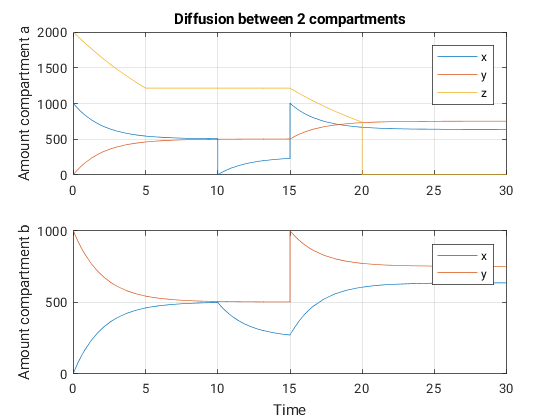

In [28]:
% plot
h1 = subplot(2,1,1);
plot(h1, t, x(:,1:3));
h2 = subplot(2,1,2);
plot(h2, t, x(:,5:6));
grid(h1,'on'); 
grid(h2,'on');
title(h1,'Diffusion between 2 compartments');
ylabel(h1,'Amount compartment a');
ylabel(h2,'Amount compartment b');
xlabel(h2,'Time');
legend(h1, 'x', 'y', 'z');
legend(h2, 'x', 'y');

Finally, simulate the reaction system using STEPS for Matlab.

STEPS for Matlab does not yet support returning Simbiology SimData objects. Only the [t, x, names] convention is supported where t is a vector of time points, x the corresponding state data, and names the list of molecular species names. However, while Matlab Simbiology only supports a single realisation using this return data format convention, STEPS for Matlab also supports ensembles by extending x to a cell array, one cell per realisation. 

Input arguments. They are given as name, value pair.
- solver - 'wmdirect' or 'wmrk4', default: 'wmdirect'. Please see the STEPS documentation for details (TODO: links missing) 
- seed - set an explicit see for the pseudo random number generator. If '0' or nothing given, a seed will be generated,
- realisations - the number of realisations to be computed, default: '1',
- rk4dt - internal time step of the Runge-Kutta solver wmrk4, default: '1e-5',
- dt - increment between the time points at which the molecular populations are stored,
- stoptime - the final time up to which the simulation will be computed,
- modeltofile - boolean flag, 'True' or False'. If set to 'True', the generated STEPS model is written to a file.

In [12]:
[t,x, names] = run_steps(model, 'stoptime', 30, 'realisations', 1, 'modeltofile', true, 'solver', 'wmrk4');



              dt: 0.1000
     modeltofile: 1
    realisations: 1
           rk4dt: 1.0000e-05
            seed: 0
          solver: 'wmrk4'
        stoptime: 30


STochastic Engine for Pathway Simulation
Version:  3.1.0
License:  GPL2.0
Website:  steps.sourceforge.net
CXX Binding: SWIG
log level: info
{"data": [[[[0.0, 1000.0, 0.0, 2000.0], [19.90033250166516, 975.6147122503535, 24.385287749644604, 1980.0996674983344], [39.602653386477755, 952.4187090179876, 47.58129098200664, 1960.3973466135199], [59.10893290295271, 930.3539882125621, 69.64601178743695, 1940.8910670970472], [78.4211216953039, 909.3653765390447, 90.63462346095645, 1921.5788783046935], [97.54115099850381, 889.4003915357748, 110.599608464228, 1902.4588490015014], [116.4709328315207, 870.4091103408471, 129.59088965915853, 1883.5290671684909], [135.2123601882068, 852.3440448592605, 147.65595514073863, 1864.7876398118033], [153.76730722691497, 835.1600230176457, 164.8399769823471, 1846.2326927731], [172.13762945781397, 818.

Plot the results. Please be aware that the sequence of species in the data is not necessarily the same as in Matlab's 'sbiosimulate'.

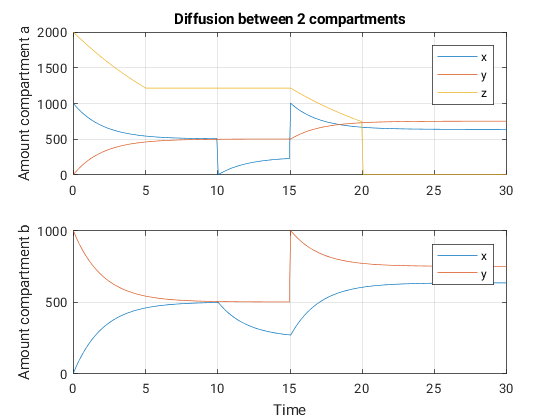

In [13]:
% plot
h1 = subplot(2,1,1);
plot(h1, t, x{1}(:,2:4));
h2 = subplot(2,1,2);
plot(h2, t, x{1}(:,6:7));
grid(h1,'on'); 
grid(h2,'on');
title(h1,'Diffusion between 2 compartments');
ylabel(h1,'Amount compartment a');
ylabel(h2,'Amount compartment b');
xlabel(h2,'Time');
legend(h1, 'x', 'y', 'z');
legend(h2, 'x', 'y');